-------CNN Training ---------
---------CNN prediction on saved model----
Final accuracy of CNN: 67.88
---------Activation Maximization---------
Inputed image trying to adjust as per class 6


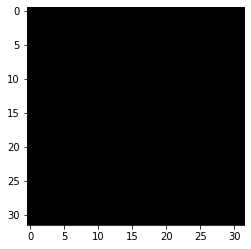

C:\Users\arsal\Anaconda3\lib\site-packages\ipykernel_launcher.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Maximised image 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


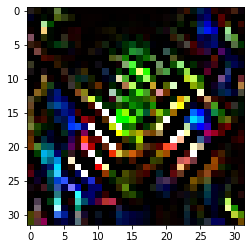

---------D Tree---------
Final Dtree score: 26.119999999999997


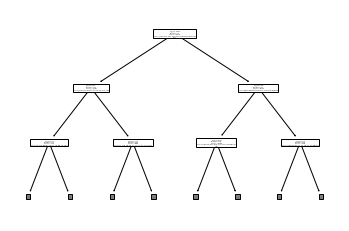

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from sklearn.preprocessing import label_binarize
import warnings
import pickle
from sklearn.metrics import accuracy_score
import sklearn.tree        # For DecisionTreeClassifier class
import sklearn.ensemble    # For RandomForestClassifier class
import sklearn.datasets    # For make_circles
import sklearn.metrics     # For accuracy_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import cv2
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)  # Print array values as 0.0023 instead of 2.352e-3
torch.set_printoptions(precision=3, sci_mode=False)
class CNN_CIFAR:
    
    def __init__(self):
        pass
    
    def unpickle(self,file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    def scale_data(self,data):
        data = data/255
        data = (2*data)-1
        return data
    
    def build_model(self):
        torch.manual_seed(0)
        
        filter_size = 5
        num_filters = 6
        pool_size = 2
        
        model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3,
                    out_channels=10,
                    kernel_size=filter_size,
                    stride = 1,
                    padding=2
                           ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=pool_size,stride = 2),
            torch.nn.Conv2d(in_channels=10,
                    out_channels=20,
                    kernel_size=filter_size,
                    stride = 1,
                    padding=2
                           ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=pool_size, stride=pool_size), 
            torch.nn.Flatten(),
            torch.nn.Linear((2*10*16**2)//pool_size**2, 80),
            torch.nn.ReLU(),
            torch.nn.Linear(80, 10),
           # torch.nn.Linear(84, 10),
        )
        model = model.float()
        return model
    
    def train_model(self,model,X_train,y_train,batch_size,epoch_num):
        #define loss function as entropy loss funcion
        model.float()
        loss = torch.nn.CrossEntropyLoss()
        loss = loss.float()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-3)
        for epoch in range(1, epoch_num+1):
            for i in range(0, len(X_train), batch_size):        
                X = X_train[i:i+batch_size]
                y = y_train[i:i+batch_size]

                y_pred = model(X)
                #print(y_pred.shape)
                #print(y.shape)
                l = loss(y_pred, torch.max(y, 1)[1])
        
                model.zero_grad()
                l.backward()
                optimizer.step()
        
            print("Epoch %d final minibatch had loss %.4f" % (epoch, l.item()))
        return model
    
    def testing(self):      
        X_dtest = self.unpickle('test_batch')
        X_test,y_test = X_dtest[b'data'],(X_dtest[b'labels'])
        X_test = self.scale_data(X_test)
        X_test = X_test.reshape(-1,3,32,32)
        y_test =  np.asarray(y_test) 
        X_test = torch.tensor(X_test)
        X_test = X_test.float()
        model = pickle.load(open('finalized_model2.sav', 'rb'))
        
        y_pred = model(X_test.float())
        
        y_predicted = np.zeros((y_pred.shape[0]))
        for i in range(y_pred.shape[0]):
             y_predicted[i] = np.where(y_pred[i] == max(y_pred[i]))[0][0]
        
        print("Final accuracy of CNN:",accuracy_score(y_test, y_predicted)*100)
               
    
    def start(self):
        print("Unpickling Data files begin")
        #unpickling the data set
        file1 = 'data_batch_1'
        file2 = 'data_batch_2'
        file3 = 'data_batch_3'
        file4 = 'data_batch_4'
        file5 = 'data_batch_5'
        test_file = 'test_batch'
        
        X_d1 = self.unpickle(file1)
        X_d2 = self.unpickle(file2)
        X_d3 = self.unpickle(file3)
        X_d4 = self.unpickle(file4)
        X_d5 = self.unpickle(file5)
        
        X_dtest = self.unpickle(test_file)
        
        print(list(X_d1.keys()))        
        
        X1,y1 = X_d1[b'data'],(X_d1[b'labels'])
        X2,y2 = X_d2[b'data'],(X_d2[b'labels'])
        X3,y3 = X_d3[b'data'],(X_d3[b'labels'])
        X4,y4 = X_d4[b'data'],(X_d4[b'labels'])
        X5,y5 = X_d5[b'data'],(X_d5[b'labels'])
        
        X_test,y_test = X_dtest[b'data'],(X_dtest[b'labels'])
        
        X = np.vstack((X1,X2,X3,X4,X5))
        y = y1+y2+y3+y4+y5
        y = np.asarray(y)
        
        model = self.build_model()
        
        #Rescaling pixel data to fit between -1 and 1
        X = self.scale_data(X)               
        X = X.reshape(-1,3,32,32)
        
        y = label_binarize(y,classes = np.arange(0,10,1))
        X,y = torch.tensor(X), torch.tensor(y)
        
        X = X.float()
        y = y.float()
        #predictions before training
        y_pred = model(X[:5].float())
            
        model = self.train_model(model,X,y,300,10)
            
        # saving trained model on the file
        filename = 'finalized_model3.sav'
        pickle.dump(model, open(filename, 'wb'))
        
        #predictions after training
        y_pred = model(X[:5].float())
        y_pred = torch.softmax(model(X[:5].float()), dim=1)
                
        return
    
    def Activation_Maximisation(self, i):
        x = torch.zeros([1, 3, 32, 32])
        print('Inputed image trying to adjust as per class', i)
        plt.imshow(torch.Tensor.cpu(x).detach().numpy()[:,:,:,:][0].transpose(1,2,0))
        plt.show() 
        x = torch.tensor(x, requires_grad=True)
        y_test = torch.tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])        
        y_test[i] = 1
        for i in range(100):
            model = pickle.load(open('finalized_model2.sav', 'rb'))
            y = model(x)
            y_predicted = np.where(y == max(y))[0][0]

            y.backward(gradient=y_test.reshape(-1,10))
            x.data += 0.1*x.grad.data

            x.grad.data.zero_()
        x=torch.Tensor.cpu(x).detach().numpy()[:,:,:,:]
        print('Maximised image ')
        plt.imshow(x[0].transpose(1,2,0))
        plt.show()  
        return

class Decision_tree:
    def unpickle(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    def start(self):
        x = np.zeros(3072)
        y = np.array([], dtype= np.int)
        for i in range(1,6):
            dicti = self.unpickle("data_batch_"+str(i))
            x = np.row_stack( ( x, np.array(dicti[b'data'] , dtype= np.uint8) )  )
            y = np.append(  y, np.array( dicti[b'labels'], dtype= np.int32) , axis = 0 )
        x = x[1:]
        dicti = self.unpickle("test_batch")
        x_test = np.array(dicti[b'data'] , dtype= np.uint8)
        y_test = np.array( dicti[b'labels'], dtype= np.int32)
        scaler = StandardScaler()
        scaler.fit(x)
        x = scaler.transform(x)
        x_test = scaler.transform(x_test)
        pca = PCA(n_components = 80)
        pca.fit(x)
        x = pca.transform(x)
        x_test = pca.transform(x_test)
        tree = sklearn.tree.DecisionTreeClassifier(random_state=0, max_depth = 5)
        tree.fit(x, y)
        sklearn.tree.plot_tree(tree, max_depth = 2)
        print("Final Dtree score:", tree.score(x_test, y_test)*100)
        return

print("-------CNN Training ---------")
# for training please uncomment the code below
obj = CNN_CIFAR()
#obj.start()
print("---------CNN prediction on saved model----")
# for testing on saved model
obj = CNN_CIFAR()
obj.testing()
print("---------Activation Maximization---------")
# You can change the class number while calling the function, which data you want to generate
obj = CNN_CIFAR()
# initially calling for frog class
obj.Activation_Maximisation(6)
print("---------D Tree---------")
obj = Decision_tree()
obj.start()